In [5]:
import scipy.io as sio
from scipy.io import readsav

import numpy as np
import math as m

import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io import fits
import pandas as pd
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import interp1d
import mpyfit

In [6]:
s = readsav('hd212657/avhd212657ccfresids.idl')
txt_file = pd.read_csv("hd212657/HD212657.RV.txt",delimiter="\t")

bjd_list = s['jdb']
rv_list = s['vrad']*1000 #m/s
rv_error = np.array((txt_file['svrad']))
ccf_list = s['ccfresids']


In [118]:
df = pd.DataFrame(list(zip(bjd_list, rv_list, ccf_list)), columns=["BJD","vrad", "CCF"])
df_sorted = df.sort_values(by=['BJD'])          

In [119]:
# title Data loader HARPS CCFs, RVs

rv_np = np.array(list(df_sorted["vrad"]-np.mean(df_sorted["vrad"])))
ccf_list_np = np.array(list(df_sorted["CCF"]))
ccf_list_np_transpose = ccf_list_np.transpose()
time_np = np.array(df_sorted["BJD"])-np.min(df_sorted["BJD"])

In [120]:
#number of columns
ccf_indexes = [15, 30, 64  ,68 , 72 ,76 , 80 , 84,  88 ,92,  96, 120, 145]

n_cols =13+5
n_rows = len(ccf_list_np) # len(ccf_list_np)<---- unsmoothed
X = np.zeros((n_rows, n_cols))

# delete this line later
period = 9.978570

X[:,0] =  1
X[:,1] =  time_np # remove for L-S
X[:,2] =  time_np**2 # remove for L-S
X[:,3] =  np.sin(2*np.pi*time_np/period) #try a whole bunch periods
X[:,4] =  np.cos(2*np.pi*time_np/period)


# add variables for every position in x per ccf. Each variable has all observations for that position in x
# if choosing random points within x evenly sampled
#for i in np.arange(0, 11):
#    X[:,i+5] = ccf_list_np_transpose[16*i] #(for all observations)

for i in np.arange(0, len(ccf_indexes)):
    X[:,i+5] = ccf_list_np_transpose[ccf_indexes[i]] #(for all observations)

#Using the smoothed over CCFs
#for i in np.arange(0, len(master_binned_center_CCFs_transpose)):
#    X[:,i+5] = master_binned_center_CCFs_transpose[i]

Y = rv_np

In [121]:
# Linear algebra operations where we write X * a_coeff = Y as
# [alpha] * a_coeff = [beta]
# where [alpha] = X^T * X
# where [beta] = X^T * Y
alpha = X.transpose().dot(X)
beta = X.transpose().dot(Y)

# and finally we can write a_coeff = alpha^-1 * beta
inv_alpha = np.linalg.inv(alpha)
a_coeff = inv_alpha.dot(beta)

In [122]:
# Define Y_bar (predicted y values) and delta_Y (Y-Y_pred)
Y_bar  = X.dot(a_coeff)
delta_Y = Y_bar - Y

# define M and N
N = len(X[0])
M = len(X)

# Define s^2
s_sq = (delta_Y.transpose().dot(delta_Y))/(M-N)

# Define s_a^2
s_a_sq = s_sq * np.diag(inv_alpha)

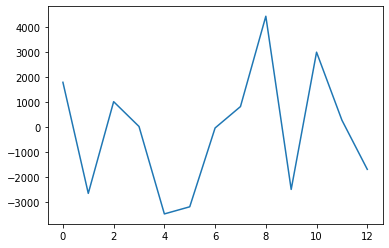

In [123]:
plt.plot(a_coeff[5:])

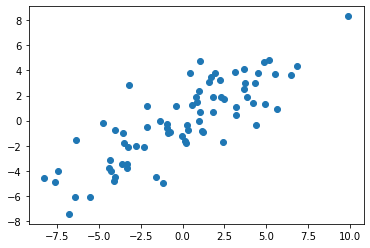

In [124]:
plt.scatter(Y, X.dot(a_coeff))

In [125]:
np.sqrt(a_coeff[3]**2+a_coeff[4]**2)

2.034006102064782

6.976580251859877
0.7901289582607657
Mass: 6.976580251859877+/- 0.7901289582607657
Radius: 2.2642141076496136+/- 0.015692573023314157


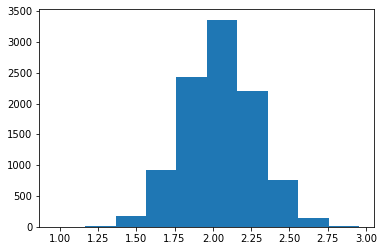

In [126]:
# error prop without error prop (monte carlo)
sd_sin = s_a_sq[3]
sd_cos = s_a_sq[4]

sin_prop = np.random.normal(a_coeff[3], sd_sin, 10000)
cos_prop = np.random.normal(a_coeff[4], sd_cos, 10000)

amplitudes =np.sqrt(sin_prop**2 + cos_prop**2)

plt.hist(amplitudes)
#print(np.median(amplitudes))
#print(np.std(amplitudes))

Mstar = 1.02 *1.989*10**30 #1.1 or 1.2 solar masses
Mstar_uncertainty = 0.12 *1.989*10**30
eccentricity =0.0
K = amplitudes

mps1 = (Mstar**2 * period * 24.0 * 3600.0 * (K)**3 * (1 - eccentricity**2)**(3.0/2.0) / (2.0 * np.pi * 6.67e-11))**(1.0/3.0) / (5.974e24)

print(np.median(mps1))
print(np.std(mps1))

mass = np.median(mps1)
mass_sd = np.std(mps1)

# Put on mass radius diagram!!

radius =  0.202*7.1492*10**7 # m
radius_e_unit = radius/ (6.3781*10**6) 
radius_uncertainty = 0.0014*7.1492*10**7
radius_uncertainty_e_unit = radius_uncertainty/ (6.3781*10**6) 

print("Mass: "+str(np.median(mps1))+"+/- "+str(np.std(mps1)))
print("Radius: "+str(radius_e_unit)+"+/- "+str(radius_uncertainty_e_unit))

418.9149000000034


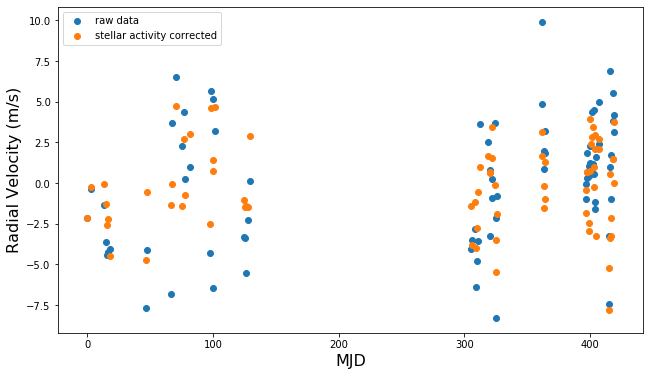

In [127]:

planet = a_coeff[3]*np.sin(2*np.pi*time_np/period)+a_coeff[4]*np.cos(2*np.pi*time_np/period)
activity_model = X.dot(a_coeff)-planet
corrected_RVs = Y-activity_model

fig, ax1 = plt.subplots(1, 1, figsize=(10.5, 6))

plt.scatter(time_np, Y, label="raw data")
plt.scatter(time_np, corrected_RVs, label="stellar activity corrected")
#plt.scatter(time_np, X.dot(a_coeff), label="predictions")

planet = a_coeff[3]*np.sin(2*np.pi*time_np/period)+a_coeff[4]*np.cos(2*np.pi*time_np/period)

activity_model = X.dot(a_coeff)-planet
#plt.scatter(time_np, a_coeff[0]+a_coeff[1]*time_np+a_coeff[2]*time_np**2+planet, label = "Keplerians")
#plt.scatter(time_np, X.dot(a_coeff)-planet, label = "Stellar model predictions")

plt.legend(loc="upper left")
plt.xlabel("MJD", size=16)
plt.ylabel("Radial Velocity (m/s)", size=16)
print(np.max(time_np))

In [128]:
phase = (time_np)%period
df_rv= pd.DataFrame(list(zip(phase,planet)), 
               columns =['phases',"planet",]) 
df_sorted = df_rv.sort_values(by=['phases'])

/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


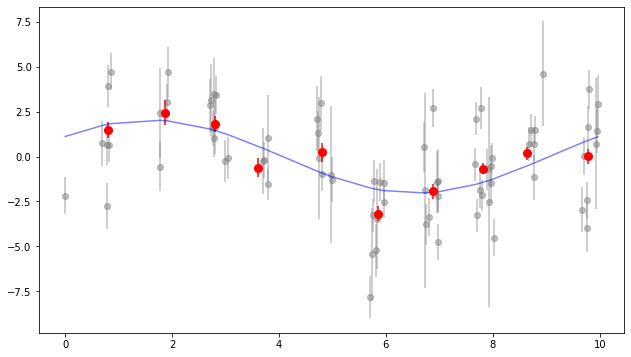

In [129]:
#binning
uncorrected_RVs = Y
corrected_RVs = Y-activity_model
phase = (time_np)%period
binned_RVs = [] 
binned_phases = []
binned_uncertainties = []
binned_uncorr_RVs = []

for i in range(0, 11):
    index= np.where(np.abs(phase-i+0.5) < 0.5)
    weighted_avg_rv = np.sum(corrected_RVs[index]/rv_error[index]**2)/np.sum(1/rv_error[index]**2)
    weighted_avg_uncorr_rv = np.sum(uncorrected_RVs[index]/rv_error[index]**2)/np.sum(1/rv_error[index]**2)
    weighted_avg_phases = np.sum(phase[index]/rv_error[index]**2)/np.sum(1/rv_error[index]**2)
    weighted_avg_uncertainty= np.sqrt(1.0/np.sum(1.0/s_rv_list[index]**2))
    binned_RVs.append(weighted_avg_rv)
    binned_uncorr_RVs.append(weighted_avg_uncorr_rv)
    binned_phases.append(weighted_avg_phases)
    binned_uncertainties.append(weighted_avg_uncertainty)

fig, ax1 = plt.subplots(1, 1, figsize=(10.5, 6))


plt.errorbar(phase, Y-activity_model, yerr = rv_error, fmt = 'o', color='grey', alpha=0.5, label="activity model", zorder=1)
#plt.errorbar(binned_phases, binned_uncorr_RVs, yerr = binned_uncertainties, fmt = 'o', color='b', alpha=1, markersize = 8, label="planet fit", zorder=1)
plt.errorbar(binned_phases, binned_RVs, yerr = binned_uncertainties, fmt = 'o', color='r', alpha=1, markersize = 8, label="planet fit", zorder=2)
plt.plot(df_sorted["phases"], df_sorted["planet"], color='b',zorder=2, alpha=0.5, label="planet fit")


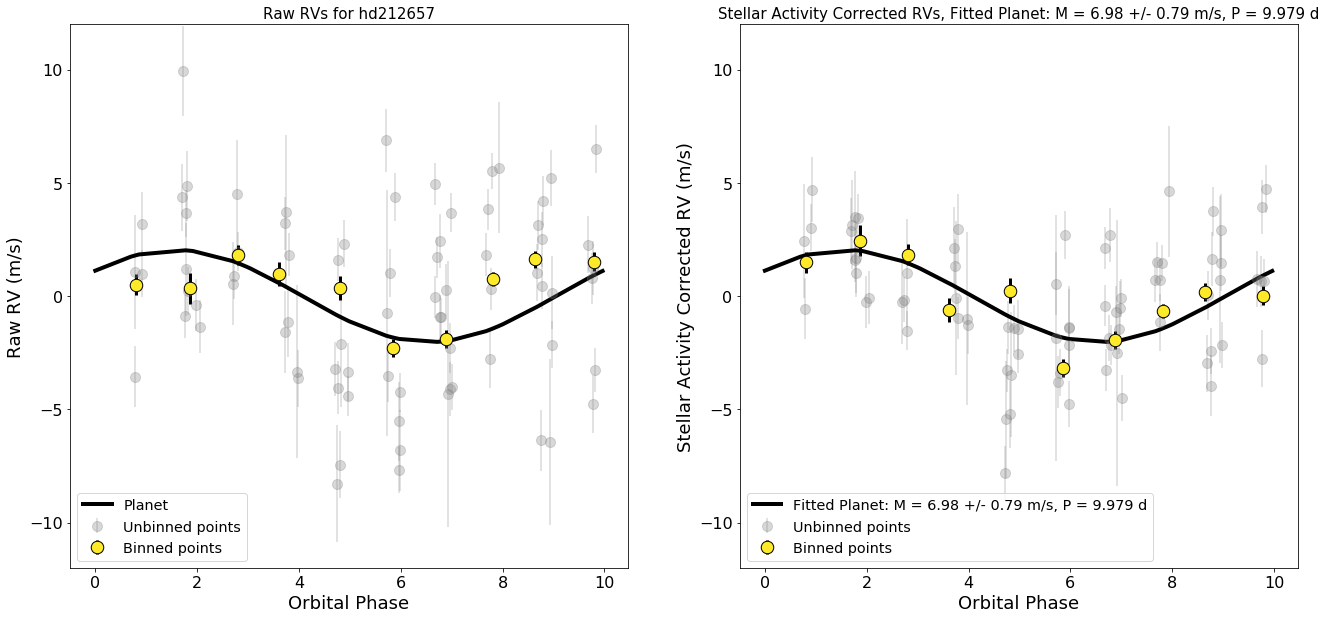

In [130]:
fig, ax = plt.subplots(1,2,figsize=(22, 10))

phase = (time_np-1)%period

# UNcorrected RVs
ax[0].errorbar(phase, Y, yerr = s_rv_list, ecolor= 'grey', 
            color='grey',linestyle='none',marker='.', markersize=20, alpha=0.3, label="Unbinned points")

ax[0].plot(df_sorted["phases"], df_sorted["planet"],
        'k',linewidth=4, 
        label="Planet")
#ax.plot(x_range, amplitude_true*np.sin(B_true*x_range+C_true), 'b',linewidth=6, label="Injected Planet Signal")
ax[0].errorbar(binned_phases, binned_uncorr_RVs, yerr = binned_uncertainties, elinewidth=3,ecolor='k',
            color='#FFEA29',linestyle='none',marker='.', markersize=25, markeredgewidth=1, 
            markeredgecolor='k', label="Binned points")
ax[0].set_ylim(-12,12)
#ax.set_xlim(-period_mcmc/2,period_mcmc/2)
ax[0].set_xlabel('Orbital Phase', size=18)
ax[0].set_ylabel('Raw RV (m/s)', size=18)

ax[0].set_title('Raw RVs for hd212657', size=15)
#             str(period), size=15) #, m = 0.5Me
ax[0].legend(loc='lower left', fontsize='x-large')



# corrected RVs
ax[1].errorbar(phase, Y-activity_model, yerr = rv_error, ecolor= 'grey', 
            color='grey',linestyle='none',marker='.', markersize=20, alpha=0.3, label="Unbinned points")

ax[1].plot(df_sorted["phases"], df_sorted["planet"],
        'k',linewidth=4, 
        label='Fitted Planet: M = '+str(round(mass, 2))+" +/- "+str(round(mass_sd, 2))+" m/s, P = "+
            str(round(period, 3))+" d")
#ax.plot(x_range, amplitude_true*np.sin(B_true*x_range+C_true), 'b',linewidth=6, label="Injected Planet Signal")
ax[1].errorbar(binned_phases, binned_RVs, yerr = binned_uncertainties, elinewidth=3,ecolor='k',
            color='#FFEA29',linestyle='none',marker='.', markersize=25, markeredgewidth=1, 
            markeredgecolor='k', label="Binned points")
ax[1].set_ylim(-12,12)
#ax.set_xlim(-period_mcmc/2,period_mcmc/2)
ax[1].set_xlabel('Orbital Phase', size=18)
ax[1].set_ylabel('Stellar Activity Corrected RV (m/s)', size=18)

ax[1].set_title('Stellar Activity Corrected RVs, Fitted Planet: M = '+str(round(mass, 2))+" +/- "+str(round(mass_sd, 2))+" m/s, P = "+
            str(round(period, 3))+" d", size=15)
#             str(period), size=15) #, m = 0.5Me
ax[1].legend(loc='lower left', fontsize='x-large')


for index_1 in [0,1]:
    ax[index_1].tick_params(axis='x', labelsize= 16) #to Set Matplotlib Tick Labels Font Size
    ax[index_1].tick_params(axis='y', labelsize= 16)

## MCMC Fitting Code Using Dan Foreman-Mackey's emcee

In [131]:
import emcee